- 신경망의 가중치 매개변수의 기울기(정확히는 가중치 매개변수에 대한 손실 함수의 기울기)는 수치 미분을 사용해 구했습니다. 수치 미분은 단순하고 구현하기도 쉽지만 계산 시간이 오래 걸린다는 게 단점입니다. 이번 장에서는 가중치 매개변수의 기울기를 효율적으로 계산하는 '오차역전파법 backpropagation'을 배워보겠습니다.

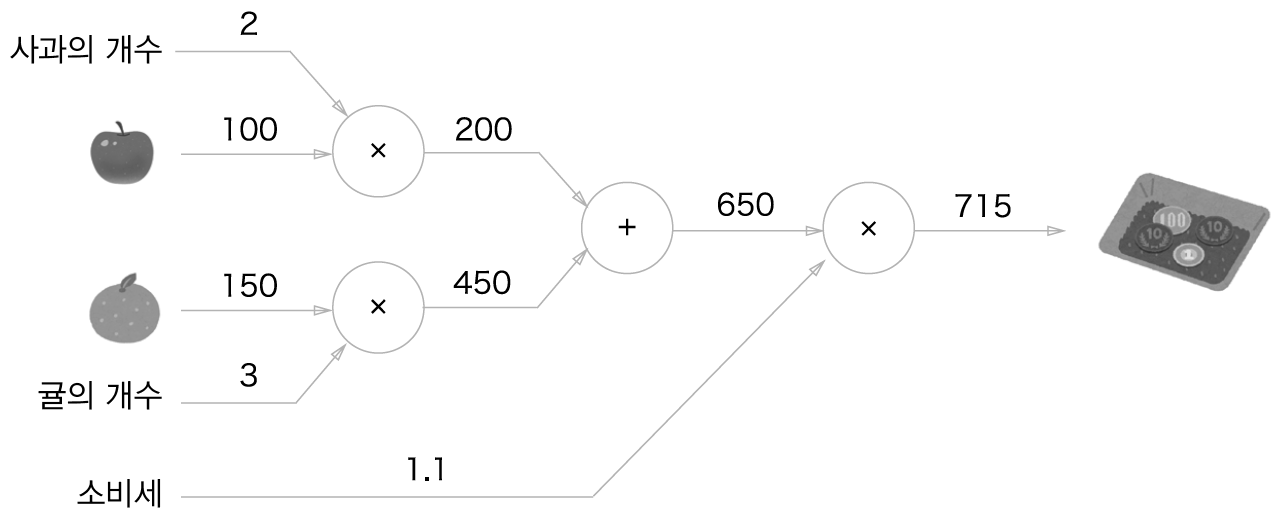

1. 계산 그래프를 구성한다.
2. 그래프에서 계산을 왼쪽에서 오른쪽으로 진행한다.
- 여기서 2번째 '계산을 왼쪽에서 오른쪽으로 진행'하는 단계를 순전파 forward propagation라고 합니다. 순전파는 계산 그래프의 출발점부터 종착점으로의 전파입니다. 순전파라는 이름이 있다면 반대 방향도 가능합니다. 그것을 역전파 backward propagation라고 합니다. 역전파는 이후에 미분을 계산할 때 중요한 역할을 합니다.

- 비유하자면 복잡한 자동차 조립은 일반적으로 '조립 라인 작업'에 의한 분업으로 행해집니다. 각 담당자(담당 기계)는 단순화된 일만 수행하며 그 일의 결과가 다음 담당자로 전달되어 최종적으로 차를 완성합니다. 계산 그래프도 복잡한 계산을 '단순하고 국소적 계산'으로 분할하고 조립 라인 작업을 수행하며 계산 결과를 다음 노드로 전달합니다. 복잡한 계산도 분해하면 단순한 계산으로 구성된다는 점은 자동차 조립과 마찬가지 인 것이죠.

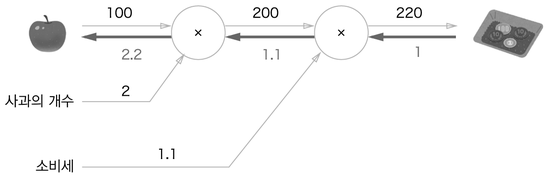

- 역전파는 오른쪽에서 왼쪽으로 '1-> 1.1-> 2.2'순으로 미분 값을 전달합니다. 이 결과로부터 '사과 가격에 대한 지불 금액의 미분'값은 2.2라 할 수 있습니다. 사과가 1원 오르면 최종 금액은 2.2원 오른다는 뜻이죠(정확히는 사과 값이 아주 조금 오르면 최종 금액은 그 아주 작은 값의 2.2배만큼 오른다는 뜻입니다).

- 합성 함수의 미분은 합성 함수를 구성하는 각 함수의 미분의 곱으로 나타낼 수 있다.

- 신경망을 구성하는 '계층' 각각을 하나의 클래스로 구현합니다. 여기에서 말하는 '계층'이란 신경망의 기능 단위입니다. 예를 들어 시그모이드 함수를 위한 Sigmoid, 행렬 곱을 위한 Affine 등의 기능을 계층 단위로 구현합니다. 그래서 이번 절에서도 곱셈 노드와 덧셈 노드를 '계층'단위로 구현합니다.

In [1]:
# coding: utf-8


class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y): #순전파 처리
        self.x = x
        self.y = y                
        out = x * y

        return out

    def backward(self, dout): #역전파 처리
        dx = dout * self.y  # x와 y를 바꾼다.
        dy = dout * self.x

        return dx, dy


class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy


In [2]:
# coding: utf-8
from layer_naive import *

apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)


price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


In [4]:
class Relu:
    def __init__(self):
        self.mask=None #인스턴스 변수
        
    def forward(self,x):
        self.mask=(x<=0)
        out=x.copy()
        out[self.mask]=0
        
        return out
    
    def backward(self,dout):
        dout[self.mask]=0
        dx=dout
        
        return dx

In [6]:
import numpy as np
x=np.array([[1.0,-0.5],[-2.0,3.0]])
print(x)

[[ 1.  -0.5]
 [-2.   3. ]]


In [7]:
mask=(x<=0)
print(mask)

[[False  True]
 [ True False]]


- ReLU 계층은 전기 회로의 '스위치'에 비유할 수 있습니다. 순전파 때 전류가 흐르고 있으면 스위치를 ON으로 하고, 흐르지 않으면 OFF로 합니다. 역전파 때는 스위치가 ON이라면 전류가 그대로 흐르고, OFF면 더 이상 흐르지 않습니다.

In [8]:
class Sigmoid:
    def __init__(self):
        self.put=None
        
    def forward(self,x):
        out=1/(1+np.exp(-x))
        self.out=out
        return out
    def backward(self,dout):
        dx=dout*(1.0-self.out)*self.out
        return dx

In [10]:
X=np.random.rand(2)
W=np.random.rand(2,3)
B=np.random.rand(3)

X.shape
W.shape
B.shape

Y=np.dot(X,W)+B

신경망의 순전파 때 수행하는 행렬의 곱은 기하학에서는 어파인 변환 affine transformation이라고 합니다. 그래서 이 책에서는 어파인 변환을 수행하는 처리를 'Affine 계층'이라는 이름으로 구현합니다.

In [12]:
X_dot_W=np.array([[0,0,0],[10,10,10]])
B=np.array([1,2,3])
X_dot_W

array([[ 0,  0,  0],
       [10, 10, 10]])

In [13]:
X_dot_W+B

array([[ 1,  2,  3],
       [11, 12, 13]])

In [14]:
dY=np.array([[1,2,3],[4,5,6]])
dY

array([[1, 2, 3],
       [4, 5, 6]])

In [15]:
dB=np.sum(dY,axis=0)

In [16]:
dB

array([5, 7, 9])

In [19]:
class Affine:
    def __init__(self,W,b):
        self.W=W
        self.b=b
        self.x=None
        self.dW=None
        self.db=None
    def forward(self,x):
        self.x=x
        out=np.dot(x,self.W)+self.b

# Softmax-with-Loss 계층 
- 마지막으로 출력층에서 사용하는 소프트맥스 함수에 관해 설명하겠습니다. 소프트맥스 함수는 입력 값을 정규화하여 출력합니다. 예를 들어 손글씨 숫자 인식에서의 Softmax 계층의 출력은 다음과 같습니다.
- 입력 이미지가 Affine 계층과 ReLU 계층을 통과하며 변환되고, 마지막 Softmax 계층에 의해서 10개의 입력이 정규화 된다. 이 그림에서는 숫자 '0'의 점수는 5.3이며, 이것이 Softmax 계층에 의해서 0.008(0.8%)로 변환된다. 또 '2'의 점수는 10.1에서 0.991(99.1%)로 변환된다.

- 신경망에서 수행하는 작업은 **학습** 과 **추론** 두 가지 입니다. 추론할 때는 일반적으로 Softmax 계층을 사용하지 않습니다. 예컨데 신경망을 추론할 때는 마지막 Affine계층의 출력을 인식 결과로 이용합니다. 또한, 신경망에서 정규화하지 않는 출력 결과 (Softmax앞의 Affine 계층의 출력)를 점수 score라고 합니다. 즉, 신경망 추론에서 답을 하나만 내는 경우에는 가장 높은 점수만 알면 되니 Softmax 게층은 필요 없다는 것이죠. 반면, 신경망을 학습할 때는 Softmax 계층이 필요합니다.

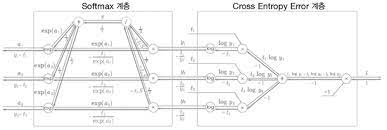

In [20]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y=None
        self.t=None
    
    def forward(self,w,t):
        self.t=t
        self.y=softmax(x)
        self.loss=cross_entropy_error(self.y,self.t)
        return self.loss
    
    def backward(self,dout=1):
        batch_size=self.t.shape[0]
        dx=(self.y-self.t)/batch_size
        
        return dx

# 신경망 학습의 순서
### 전제
- 신경망에는 적응 가능한 가중치와 편향이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라 합니다. 신경망 학습은 다음과 같이 4단계로 수행합니다.
1. 1단계 - 미니 배치
- 훈련 데이터 중 일부를 무작위로 가져옵니다. 이렇게 선별한 데이터를 미니배치라 하며, 그 미니배치의 손실 함수 값을 줄이는 것이 목표입니다.
2. 2단계 - 기울기 산출
- 미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구합니다. 기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시합니다.
3. 3단계 - 매개변수 갱신
- 가중치 매개변수를 기울기 방향으로 아주 조금 갱신합니다.
4. 4단계 - 반복
- 1~3단계를 반복합니다.


- 지금까지 설명한 오차역전파법이 등장하는 단계는 두 번쨰인 '기울기 산출'입니다. 앞 장에서는 이 기울기를 구하기 위해서 수치 미분을 사용했지요. 그런데 수치 미분은 구현하기는 쉽지만 계산이 오래 걸렸습니다. 오차역전파법을 이용하면 느린 수치 미분과 달리 기울기를 효율적이고 빠르게 구할 수 있습니다.

In [22]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 절대 오차의 평균을 구한다.
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))


W1:4.4820516859577797e-10
b1:2.22953456912949e-09
W2:6.467097410761658e-09
b2:1.398063982901987e-07


- 위 결과는 수치 미분과 오차역전파법으로 구한 기울기의 차이가 매우 작다고 말해줍니다. 가령 1번째 층의 편향 오차는 4.4e-10(0.00000000000097)입니다. 이로써 오차역전파법으로 구한 기울기도 올바름이 드러나면서 실수 없이 구현했다는 믿음이 커지는 것이죠.  
- 수치 미분과 오차역전파법의 결과 오차가 0이 되는 일은 드뭅니다. 이는 컴퓨터가 할 수 있는 계산의 정밀도가 유한하기 때문입니다(가령 32비트 부동소수점). 이 정밀도의 한계 때문에 오차는 대부분 0이 되지는 않지만, 올바르게 구현했다면 0에 아주 가까운 작은 값이 됩니다. 만약 그 값이 크면 오차역전파법을 잘못 구현했다고 의심해봐야 하겠죠.

In [23]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)

import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)


0.11576666666666667 0.1131
0.9034333333333333 0.9073
0.9197833333333333 0.9188
0.9351166666666667 0.9329
0.9442666666666667 0.943
0.9503 0.9464
0.9557333333333333 0.9513
0.9601166666666666 0.9571
0.96395 0.9592
0.9656166666666667 0.9594
0.96745 0.9602
0.9715333333333334 0.9639
0.9720666666666666 0.9634
0.97395 0.9662
0.9761 0.9683
0.9781833333333333 0.968
0.97845 0.968


- forward : 데이터를 순방향으로 전파
- backward : 데이터를 역방향으로 전파함으로써 가중치 매개변수의 기울기를 효율적으로 구할 수 있다.
- 이처럼 동작을 계층으로 모듈화한 덕분에, 신경망의 계층을 자유롭게 조합하여 원하는 신경망을 쉽게 만들 수 있다. 

- 계산 그래프를 이용하면 계산 과정을 시각적으로 파악할 수 있다.
- 계산 그래프의 노드는 국소적 계산으로 구성된다. 국소적 계싼을 조합해 전체 계산을 구성한다.
- 계산 그래프의 순전파는 통상의 계산을 수행한다. 한편, 계산 그래프의역전파로는 각 노드의 미분을 구할 수 있다.
- 신경망의 구성 요소를 계층으로 구현하여 기울기를 효율적으로 계산할 수 있다(오차역전파법).
- 수치 미분과 오차역전파법의 결과를 비교하면 오차역전파법의 구현에 잘못이 없는지 확인할 수 있다(기울기 확인).